# Numerical Optimization

## Introduction

We consider convex problems with sufficient regularity, such that gradient information may be used. Algorithms that use these properties can be broadly classified as either **Line Search** methods or **Trust Region** methods. The exposition here follors Nocedal and Wright, which is an excellent introduction to the topic. I am not aiming for mathematical rigor, nor for completeness. Rather, I would like to revise some of the key concepts myself and give a nice first introduction, complete with the intuition and some working code.


### Preparation

Before we explore some approaches, we need a differentiable function complete with gradient information. As we want make ourselves familiar with ML-relevant tools out there, we will make use of the library PyTorch and its auto-differentiation capabilities. As usual, numpy and matplotlib will be useful as well:

**Disclaimer:** the code in this article could be greatly simplified by just using numpy instead of PyTorch. If you are mainly interested in numerical optimization, I suggest to do this, as this will clarify the core concepts.

In [414]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.autograd as autograd

Let us define a two-dimensional objective function, which we will be minimizing.

In [476]:
d = 2

# random quadratic form
class quadratic_form(torch.nn.Module):
  def __init__(self, D_in):
    super().__init__()
    self.c = torch.randn(1)
    self.b = torch.randn(D_in, 1) # we do not use these, however I kept them for completeness, if we want a general quadratic form.
    self.A = np.random.standard_exponential((D_in,D_in))
    self.A = torch.from_numpy(self.A).float()
    self.A = self.A.T @ self.A # to ensure that A is a symmetric matrix
  def forward(self, x):
    y = torch.sum(x * (self.A@x), 0) # - 2.0 * self.b.T @ x + self.c
    return y

As we are using PyTorch, we can make use of auto-differentiation to evaluate the gradient information with respect to the input $x$. A nice introduction to autograd in PyTorch can be found [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).

In [477]:
objective_function = quadratic_form(d)

# getting the gradient
x0 = torch.rand(2,1, requires_grad=True)
f0 = objective_function(x0) # forward pass
f0.backward() # after having computed one step, this will compute the gradient
print(x0.grad)

tensor([[1.0852],
        [1.1448]])


Bingo! We will also need a function to visualize our minimizer:

In [494]:
def plot_minimizier(f, bounds=[-10, 10, -10, 10], trace=np.empty(0)):
  x = np.linspace(bounds[0], bounds[1], 40, dtype=np.float32)
  y = np.linspace(bounds[2], bounds[3], 40, dtype=np.float32)
  X, Y = np.meshgrid(x, y)
  grid = np.vstack((X.flatten(),Y.flatten()))
  Z = f(torch.from_numpy(grid))
  Z = np.reshape(Z.detach().numpy(), (40,40))

  plt.gca().set_aspect("equal")
  plt.gcf().set_size_inches(7.5, 5.5)
  contourplot = plt.contourf(X, Y, Z, levels=np.linspace(np.amin(Z),np.amax(Z),50))
  cbar = plt.colorbar(contourplot)

  # plot a sequence of points to visualize the optimization process
  trace = np.array(trace)
  if trace.size != 0:
    plt.plot(trace[:,0], trace[:,1],'w.', linestyle='dashed')
    plt.show()

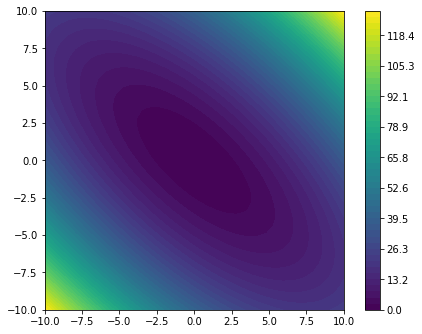

In [479]:
plot_minimizier(objective_function)

We observe that the `objective_function` is a quadratic form with its minimum located at $(0, 0)^T$.

### Taylor's theorem

To illustrate both approaches, let us start with Taylor's theorem. Suppose that $f: \mathbb{R}^d \rightarrow \mathbb{R}$  is continuously differentiable and that $p \in \mathbb{R}^d$. Then, we have that

$$f(x+p) = f(x) + \nabla f(x + tp)^T p,$$

for some $t \in (0,1)$. Furthermore, if $f$ is twice continuously differentiable,

$$\nabla f(x+p) = \nabla f(x) + \int_0^1 \nabla^2 f(x+tp) p\;\mathrm{d}t,$$

which implies

$$f(x+p) = f(x) + \nabla f(x)^T p + \frac{1}{2}p^T \nabla^2 f(x+tp) p,$$

for some $t \in (0,1)$. Here, we have introduced the vector-valued gradient $\nabla f$ and the $d \times d$ Hessian matrix $\nabla^2 f$.

The latter implies $f(x+p) < f(x)$ for $p = - \alpha \nabla f(x)$, if some sufficiently small $\alpha$ is chosen. We can therefore update $x$ sequentially, such that $f(x)$ keeps decreasing, thus converging to a minimum.

## Line Search methods

This idea brings us to line-search methods. The core idea of Line Search method is to update the solution $x_k$ iteratively according to

$$x_{k+1} = x_k + \alpha_k p_k,$$

where $p_k$ is a descent direction (which is not necessarily the negative gradient) and $\alpha_k$ a certain step size. Ideally, this will result in a decreasing sequence

$$f(x_0) \geq f(x_1) \geq \dots \geq f(x_{k-1}) \geq f(x_k)$$

which converges to a certain minimum. These approaches are also called line-search methods, as we are looking for the minimum across the line defined by the search direction $p_k$. It is evident that convergence will depend on the specific choice of the descent direction $p_k$ and step size $\alpha_k$.

### Gradient descent

The natural choice for $p_k$ is to take the direction of steepest descent $-\nabla f(x_k)$. Taking the appropriate step size is a more difficult problem to solve. This leaves the choice regarding the step size open. A popular strategy is the so-called backtracking line-search. At each iteration, the following algorithm will give us a step-size $\alpha$:

In [480]:
def backtrack(f, x0, p0, alpha, tau=0.5, c=0.5):
  f0 = f(x0)
  m = torch.norm(p0) ** 2
  t = c * m
  while f0 - f(x0 + alpha * p0) <= alpha * t:
    alpha = tau*alpha
  return alpha


In other words, we start out with a certain step size $\alpha$ and decrease it iteratively as long as $f(x_0) - f(x_0 + \alpha p_0) \geq \alpha c ||p_0||^2$ is satisfied. $\tau \in (0,1)$ and $c \in (0,1)$ are some control parameters, which determine the behavior of the method. $\tau \in (0,1)$ is some shrinkage parameter, which controls the decay of $\alpha$, which is replaced by $\tau \alpha$ at each iteration. The parameter controls the maximal step size, as $\alpha$ will satisfy

$$f(x_0 + \alpha p_0) \leq f(x_0) + \alpha c ||p_0||^2,$$

which is also known as the Armijo–Goldstein condition (insert reference and say something about convergence).

Now that we have a method for choosing a step size, we can proceed by iteratively updating

In [481]:
def gradient_descent(f, x0, alpham=1.0, tol=1e-6):

  # initialize the procedure
  x = x0
  x.requires_grad = True
  f0 = f(x)
  f0.backward()
  p = - x.grad
  alpha = alpham

  # track the progress in trace
  trace = [x.detach().numpy()]

  # iterate 
  k = 0
  while k < 100 and alpha > tol:
    # for the following steps, we do not wish to track gradient information
    # to the end, we use torch.no_grad()
    with torch.no_grad():
      alpha = backtrack(f, x, p, alpham)
      x = x + alpha * p
    trace.append(x.detach().numpy())
    x.requires_grad = True
    f.zero_grad()
    f0 = f(x)
    f0.backward()
    p = - x.grad
    k += 1
  # compute the Wolfe condition
  return trace

x0 = torch.tensor([[10.],[10.]], requires_grad=True)
trace = gradient_descent(objective_function, x0)
  

We run the iteration 100 times or until the step size becomes too small. This gives us the following output, which is a list containing each of the iterates $x_k$:

In [482]:
trace

[array([[10.],
        [10.]], dtype=float32),
 array([[3.7949867],
        [3.311122 ]], dtype=float32),
 array([[1.5691917],
        [0.9673536]], dtype=float32),
 array([[0.75595737],
        [0.15985131]], dtype=float32),
 array([[ 0.44580787],
        [-0.10599434]], dtype=float32),
 array([[ 0.3162951],
        [-0.1822076]], dtype=float32),
 array([[ 0.18957567],
        [-0.20425835]], dtype=float32),
 array([[ 0.16430563],
        [-0.14100039]], dtype=float32),
 array([[ 0.1231923 ],
        [-0.11516391]], dtype=float32),
 array([[ 0.09740282],
        [-0.08819293]], dtype=float32),
 array([[ 0.07548606],
        [-0.06917098]], dtype=float32),
 array([[ 0.05893937],
        [-0.05376745]], dtype=float32),
 array([[ 0.04589118],
        [-0.0419344 ]], dtype=float32),
 array([[ 0.03576905],
        [-0.03266454]], dtype=float32),
 array([[ 0.02786863],
        [-0.02545578]], dtype=float32),
 array([[ 0.02171637],
        [-0.01983445]], dtype=float32),
 array([[ 0.01692136

Let us use the plotting routine from before to visualize the minimization process.

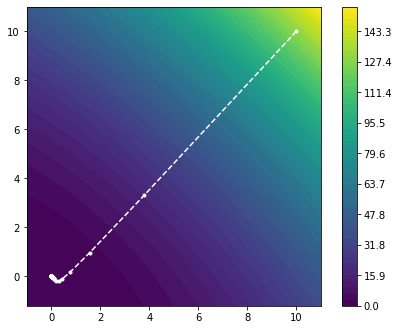

In [483]:
trace = np.array(trace)
bounds = [np.amin(trace[:,0]) - 1., np.amax(trace[:,0]) + 1., np.amin(trace[:,1]) - 1., np.amax(trace[:,1]) + 1.]
plot_minimizier(objective_function, bounds=bounds, trace=trace)

Very good! We can see that the updates are parallel to the gradient and move in the direction of steepest descent as we expected. Moreover, we observe that the step sizes $\alpha_k$ seem to be chosen reasonably, such that the method converges to the minimum. In fact, the Armillo-Goldstein condition with the chosen parameter is sufficient to guarantee convergence for a strictly convex function (insert ref.).

Let us now try another example, the Rosenbrock function $f(x_1, x_2) = (1-x_1)^2 + 100 (x_2 - x_1^2)^2$, which is a pathological example, with a narrow, curved valley. This proves to be difficult for gradient descent methods. Let us define the function and apply gradient descent:

In [484]:
# We also need a pathological case
class rosenbrock_function(torch.nn.Module):
    def __init__(self):
      super().__init__()
    def forward(self, x):
      y = (1.0 - x[0])**2 + 100*(x[1]-x[0]**2)**2
      return y

objective_function = rosenbrock_function()

x0 = torch.tensor([[-1.],[1.]], requires_grad=True)
f0 = objective_function(x0)
trace = gradient_descent(objective_function, x0)

...and we visualize the result:

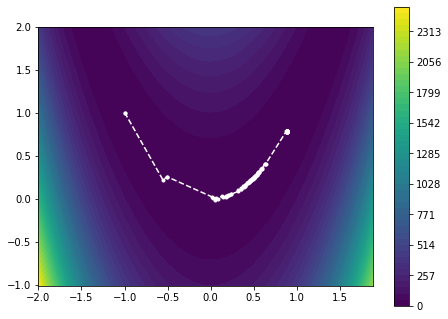

In [485]:
trace = np.array(trace)
bounds = [np.amin(trace[:,0]) - 1., np.amax(trace[:,0]) + 1., np.amin(trace[:,1]) - 1., np.amax(trace[:,1]) + 1.]
plot_minimizier(objective_function, bounds=bounds, trace=trace)

We observe that many iterations are spent zig-zagging in the curved part of the solution. This is understandable, considering that the gradient-descent method is moving in the "wrong" direction and therefore has to adjust the descent direction frequently.

## Trust region methods

The previous problem nicely illustrated the need for a smarter choice of the descent direction $p_k$. An alternative approach can be derived upon closer inspection of Taylor's theorem. If $f$ has sufficient regularity, the function $f$ can be approximated locally around $x$ with the quadratic form

$$f(x+p) = f(x) + \nabla f(x)^T p + \frac{1}{2} p^T \, \nabla^2 f(x) \, p + \mathcal{O}(||p||^3).$$

By differentiating this with respect to $p$ and setting the result to zero, we find $p^*$, which minimizes this quadratic form. $p^*$ satisfies

$$\nabla^2 f(x) \, p^* = - \nabla f(x),$$

which can be solved to obtain $p^* = - (\nabla^2 f(x))^{-1} \nabla f(x)$.

### Newton method

This gives rise to the Newton method. At each iteration, we compute the local quadratic approximation to $f$ and set $x_{k+1} = x_{k} + p_k^*$ to be the minimizer of this local approximation. Coincidentally, this is equivalent tothe application of *Newton's method for root-finding* to the Gradient $\nabla f(x)$, as we are essentially looking for a root of $\nabla f(x)$.


In [491]:
def newton_method(f, x0):

  # initialize the procedure
  x = x0
  x.requires_grad = True

  # track the progress in trace
  trace = [x.detach().numpy()]

  # iterate 
  k = 0
  while k < 20:
    # compute the gradient and Hessian
    H = torch.autograd.functional.hessian(f, x, create_graph=False).squeeze()
    f0 = f(x)
    f0.backward()
    # solve the linear system and compute the update
    with torch.no_grad():
      p = - torch.linalg.solve(H, x.grad)
      x = x + p
    
    trace.append(x.detach().numpy())
    x.requires_grad = True
    f.zero_grad()
    k += 1
  # compute the Wolfe condition
  return trace

objective_function = quadratic_form(d)
x0 = torch.tensor([[10.],[10.]], requires_grad=True)
trace = newton_method(objective_function, x0)

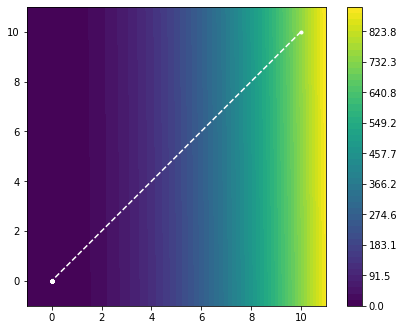

In [492]:
trace = np.array(trace)
bounds = [np.amin(trace[:,0]) - 1., np.amax(trace[:,0]) + 1., np.amin(trace[:,1]) - 1., np.amax(trace[:,1]) + 1.]
plot_minimizier(objective_function, bounds=bounds, trace=trace)

As we can see, the Newton method converged to the minimum in one step. This is hardly surprising as we have essentially approximated a quadratic form with a itself. As such, we find the global minimum in one step. Let us see how this method performs on the Rosenbrock function.

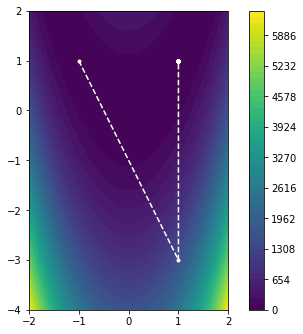

In [493]:
objective_function = rosenbrock_function()

x0 = torch.tensor([[-1.],[1.]], requires_grad=True)
trace = newton_method(objective_function, x0)

trace = np.array(trace)
bounds = [np.amin(trace[:,0]) - 1., np.amax(trace[:,0]) + 1., np.amin(trace[:,1]) - 1., np.amax(trace[:,1]) + 1.]
plot_minimizier(objective_function, bounds=bounds, trace=trace)

The Newton method converges to the desired solution in only two iterations, completely avoiding the previous problem. So, if the Newton method performs so well, why do we not always use it? The improved performance of the Newton method comes at the cost of evaluating the $d \times d$ Hessian matrix $\nabla^2 f(x)$ at each iteration and solving the linear system $\nabla^2 f(x) \, p^* = -  \nabla f(x)$. While this alone can be fairly prohibitive, there is also the question of regularity, as $f$ may not necessarily be smooth enough to have a Hessian everywhere. In other words, a local approximation with a quadratic form may not necessarily be a good approximation in such cases.

Some algorithms try to alleviate the former problem of having to form the Hessian by only approximating it. This can be done in the gradient descent approach, by keeping track of the chenge in the descent direction and using this information to approximate the Hessian. The latter problem of insufficient regularity can be addressed by switching between line search approaches and trust region methods depending on the local smoothness of $f$.

## Analogy to linear systems

Coming from numerical linear algebra, I couldn't resist to introduce some linear algebra. A central problem of numerical linear algebra is the solution of linear systems of the form $Ax = b$, where $A \in \mathbb{R}^{m \times m}$ and $x, b \in \mathbb{R}^m$. We note that in this formulation, the problem may have either exactly one solution, infinitely many, or none at all. We can re-cast this problem by defining the objective function

$$f(x) = x^T A x - 2 x^T b.$$



... Why is this interesting? There are numberous algorithms for the solution of linear systems. It is only reasonable that some of them may therefore be understood as minimization algorithms with respect to $f$, therefore giving us alternative optimization algorithms.

## Conclusion

Numerical optimization is a fascinating field and we have not even discussed convergence properties and more sophisticated algorithms. With the recent explosion of non-linear machine learning models, It is evident, that numerical optimization will be one of the core tools in the 

In the following, I have included some references that I found useful, as well as references for further reading. Enjoy, and until next time!
## References